# Exploring a generic Markov model of chromatin accessibility

Last updated by: Jonathan Liu, 4/23/2021

Here, we will explore a generic Markov chain model of chromatin accessibility, where we model chromatin with a series of states and Markov transitions between them. Of interest is the onset time, the time it takes for the system to reach the final, transcriptionally competent state. We will indicate that the limit of equal, irreversible reactions is the limit of noise performance and that allowing for some reversibility weakens performance. We will then show that with a transient input, the model can achieve much better performance.

In [1]:
#Import necessary packages
%matplotlib inline
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import scipy.special as sps
from IPython.core.debugger import set_trace
from numba import njit, prange
import numba as numba
from datetime import date
import time as Time
import seaborn as sns

#Set number of threads
numba.set_num_threads(4)

In [2]:
# PBoC plotting style (borrowed from Manuel's github)
def set_plotting_style():
    """
    Formats plotting enviroment to that used in Physical Biology of the Cell,
    2nd edition. To format all plots within a script, simply execute
    `mwc_induction_utils.set_plotting_style() in the preamble.
    """
    rc = {'lines.linewidth': 1.25,
          'axes.labelsize': 12,
          'axes.titlesize': 12,
          'axes.facecolor': '#E3DCD0',
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'xtick.color': 'white',
          'xtick.direction': 'in',
          'xtick.top': True,
          'xtick.bottom': True,
          'xtick.labelcolor': 'black',
          'ytick.color': 'white',
          'ytick.direction': 'in',
          'ytick.left': True,
          'ytick.right': True,
          'ytick.labelcolor': 'black',
          'font.family': 'Arial',
          #'grid.linestyle': '-', Don't use a grid
          #'grid.linewidth': 0.5,
          #'grid.color': '#ffffff',
          'axes.grid': False,
          'legend.fontsize': 8}
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    #plt.rc('xtick.major', pad=5)
    #plt.rc('ytick.major', pad=5)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[3.5, 2.5])
    plt.rc('svg', fonttype='none')
    plt.rc('legend', title_fontsize='12', frameon=True, 
           facecolor='#E3DCD0', framealpha=1)
    sns.set_style('darkgrid', rc=rc)
    sns.set_palette("colorblind", color_codes=True)
    sns.set_context('notebook', rc=rc)

# Some post-modification fixes that I can't seem to set in the rcParams
def StandardFigure(ax):
    ax.tick_params(labelcolor='black')
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    
set_plotting_style()

In [3]:
#Function to generate a random transition matrix for a generic Markov chain with n states, and an irreversible
#transition into the final state.

#Inputs:
#   n: number of states
#   k_min: minimum transition rate
#   k_max: maximum transition rate

#pseudocode
#generate 2D matrix based on n
#loop over each index, if indices are connected by 1 then generate a value (except final state)
#Calculate diagonal elements from summing columns to zero
#

def MakeRandomTransitionMatrix(n, k_min, k_max):
    #Initialize the transition matrix
    Q = np.zeros((n,n))
    
    #Loop through transition indices (note that the final column is all zeros since it's an absorbing state)
    for i in range(n):
        for j in range(n-1):
            #If the indices are exactly one apart (i.e. adjacent states), then make a transition rate
            if np.abs(i-j) == 1:
                Q[i,j] = np.random.uniform(k_min,k_max)

    #Calculate the diagonal elements by taking the negative of the sum of the column
    for i in range(n-1):
        Q[i,i] = -np.sum(Q[:,i])
        
    return Q


In [4]:
#Function to generate a transition matrix for equal, irreversible transitions (i.e. Gamma distribution results)
#We assume the final state is absorbing

#Inputs:
#   n: number of states
#   k: transition rate

def MakeGammaDistMatrix(n, k):
    #Initialize the transition matrix
    Q = np.zeros((n,n))
    
    #Loop through transition indices (note that the final column is all zeros since it's an absorbing state)
    for i in range(n):
        for j in range(n-1):
            #All forward transitions are equal to k
            if i == j + 1:
                Q[i,j] = k

    #Calculate the diagonal elements by taking the negative of the sum of the column
    for i in range(n-1):
        Q[i,i] = -np.sum(Q[:,i])
        
    return Q

#Similar function for making a transition matrix with equal forward transitions of magnitude k and
#equal backward transitions of magnitude k * f
def MakeEqualBidirectionalMatrix(n, k, f):
    #Initialize the transition matrix
    Q = np.zeros((n,n))
    
    #Loop through transition indices (note that the final column is all zeros since it's an absorbing state)
    for i in range(n):
        for j in range(n-1):
            #All forward transitions are equal to k
            if i == j + 1:
                Q[i,j] = k
            elif i == j - 1:
                Q[i,j] = k * f

    #Calculate the diagonal elements by taking the negative of the sum of the column
    for i in range(n-1):
        Q[i,i] = -np.sum(Q[:,i])
        
    return Q


In [5]:
#Simulation for calculating onset times for a generic Markov chain using Gillespie algorithm
#Using vectorized formulation for faster speed

def CalculatetOn_GenericMarkovChainGillespie(Q,n,N_cells):
#Calculates the onset time for a linear Markov chain with forward and backward rates.
#The transition rate can be time-varying, but is the same
#global rate for each transition. The model assumes n states, beginning
#in the 1st state. Using the Gillespie algorithm and a Markov chain formalism, it
#simulates N_cells realizations of the overall time it takes to reach the
#nth state.

#For now, this only works with steady transition rates. Later we will modify this to account 
#for time-varying rates.

# Inputs:
#   Q: transition rate matrix, where q_ji is the transition rate from state i to j for i =/= j and 
#      q_ii is the sum of transition rates out of state i
#   n: number of states
#   N_cells: number of cells to simulate

# Outputs:
#   t_on: time to reach the final state for each cell (length = N_cells)

## Setup variables
    t_on = np.zeros(N_cells) #Time to transition to final ON state for each cell
    state = np.zeros(N_cells, dtype=int) #State vector describing current state of each cell

    ## Run simulation
    # We will simulate waiting times for each transition for each cell and stop once each cell has
    # reached the final state
    
    #Set diagonal entries in transition matrix to nan since self transitions don't count
    for i in range(n):
        Q[i,i] = 0
    
    #Construct the transition vector out of each cell's current state
    Q_states = np.zeros((N_cells,n))
    while np.sum(state) < (n-1)*N_cells:
        Q_states = np.transpose(Q[:,state])
            
        #Generate random numbers in [0,1] for each cell
        randNums = np.random.random(Q_states.shape)

        #Calculate waiting times for each entry in the transition matrix
        #Make sure to suppress divide by zero warning
        with np.errstate(divide='ignore'):
            tau = (1/Q_states) * np.log(1/randNums)

        #Find the shortest waiting time to figure out which state we transitioned to for each cell
        tau_min = np.amin(tau, axis=1)
        newState = np.argmin(tau, axis=1)
        
        #Replace infinities with zero, corresponding to having reached the final state
        newState[tau_min==np.inf] = n-1
        tau_min[tau_min==np.inf] = 0
        
        #Update the state and add the waiting time to the overall waiting time
        state = newState
        t_on += tau_min
    return t_on

In [6]:
#Simulation for calculating onset times for a generic Markov chain using Gillespie algorithm
#Using vectorized formulation for faster speed

def CalculatetOn_GenericMarkovChainGillespieTime(Q,n,t_d,N_cells):
#Calculates the onset time for a linear Markov chain with forward and backward rates.
#The transition rate can be time-varying, but is the same
#global rate for each transition. The model assumes n states, beginning
#in the 1st state. Using the Gillespie algorithm and a Markov chain formalism, it
#simulates N_cells realizations of the overall time it takes to reach the
#nth state.

#This considers time-dependent transition rates parameterized by a diffusion timescale t_d.
#The time-dependent rate has the form r ~ (1 - exp(-t/t_d)). For now, we assume only the forwards
#rates have the time-dependent profile, and that backwards rates are time-independent.

# Inputs:
#   Q: 3D transition rate matrix, where q_kji is the transition rate at time k from state i to j for i =/= j and 
#      q_kii is the sum of transition rates out of state i
#   n: number of states
#   t_d: diffusion timescale of time-dependent transition rate
#   N_cells: number of cells to simulate

# Outputs:
#   t_on: time to reach the final state for each cell (length = N_cells)

## Setup variables
    t_on = np.zeros(N_cells) #Time to transition to final ON state for each cell
    time = np.zeros(N_cells) #Vector of current time for each cell
    state = np.zeros(N_cells, dtype=int) #State vector describing current state of each cell

    ## Run simulation
    # We will simulate waiting times for each transition for each cell and stop once each cell has
    # reached the final state
    
    #Set diagonal entries in transition matrix to nan since self transitions don't count
    for i in range(n):
        Q[i,i] = 0
        
    #Define the diffusion timescale matrix t_d (finite for forwards rates, effectively 0 for backwards rates)
    t_d_mat = np.zeros((n,n))
    t_d_mat[:,:] = 0.00000001 #Non forwards transitions are essentially 0 diffusive timescale
    for i in range(n):
        for j in range(n-1):
            #Forwards rates
            if i == j + 1:
                t_d_mat[i,j] = t_d
    
    #Construct the transition vector out of each cell's current state
    Q_states = np.zeros((N_cells,n))
    #Construct the diffusion timescale vector for each cell
    t_d_states = np.zeros((N_cells,n))
    while np.sum(state) < (n-1)*N_cells:
        Q_states = np.transpose(Q[:,state])
        t_d_states = np.transpose(t_d_mat[:,state])
        
        #Construct the current time vector for each cell
        time_states = np.transpose(np.tile(time,(n,1)))
        
            
        #Generate random numbers in [0,1] for each cell
        randNums = np.random.random(Q_states.shape)

        #Calculate waiting times for each entry in the transition matrix
        #Make sure to suppress divide by zero warning
        
        #For the exponential profile, this uses the lambertw/productlog function. The steady-state
        #case corresponds to t_d -> 0.
        with np.errstate(divide='ignore', invalid='ignore'):
            #Temp variables for readability
            a = 1/Q_states * np.log(1/randNums)
            b = -np.exp(-(a + t_d_states * np.exp(-time_states/t_d_states) + time_states)/t_d_states)
            tau = np.real(t_d_states * sps.lambertw(b) + a + t_d_states *\
                          np.exp(-time_states / t_d_states))
        #Find the shortest waiting time to figure out which state we transitioned to for each cell
        tau_min = np.amin(tau, axis=1)
        newState = np.argmin(tau, axis=1)
        
        #Replace infinities with zero, corresponding to having reached the final state
        newState[tau_min==np.inf] = n-1
        tau_min[tau_min==np.inf] = 0
        
        #Update the state and add the waiting time to the overall waiting time
        state = newState
        t_on += tau_min
        time += tau_min
    return t_on

# The steady-state regime
First, let's get a feel for the model in the steady-state case. 

We consider a Markov chain with $k+1$ states labeled with indices $i$, with the first state labeled with index $0$. The system will begin in state $0$ at time $t=0$ and we will assume the final state $k$ is absorbing. For example, this could correspond to the transcriptionally competent state. We will allow for forwards and backwards transition rates between all states, except for the final absorbing state, which will have no backwards transition out of it. Denote the transition from state $i$ to state $j$ with the transition rate $\beta_{i,j}$. So,, we have the reaction network:

\begin{equation}
0 \underset{\beta_{1,0}}{\overset{\beta_{0,1}}{\rightleftharpoons}} 1 \underset{\beta_{2,1}}{\overset{\beta_{1,2}}{\rightleftharpoons}} ... \overset{\beta_{k-1,k}}{\rightarrow} k
\end{equation}

We will be interested in the mean and variance of the distribution of times $P_k(t)$ to start at state $0$ and reach the final state $k$.

We will first consider the simple case where the transition rates $\beta$ are constant in time, and that we have only forward transitions that are all equal in magnitude. In this case, the distribution $P_k(t)$ is simply given by a Gamma distribution with shape parameter $k$ and rate parameter $\beta$. $P_k(t)$ then has the form

\begin{equation}
P_k(t) = \frac{\beta^k}{\Gamma(k)}t^{k-1}e^{-\beta t}
\end{equation}

where $\Gamma$ is the Gamma function. Below we show analytical and simulated results for the distribution of onset times.



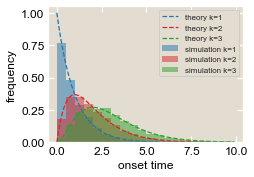

In [7]:
#Let's visualize the distribution of onset times for the Gamma distribution case

#Function for analytical Gamma distribution
def GamPDF(x,shape,rate):
    return x**(shape-1)*(np.exp(-x*rate) / sps.gamma(shape)*(1/rate)**shape)

#Pick some parameters
beta = 1 #transition rate
n = np.array([2,3,4]) #number of states
k = n-1 #Number of steps

#Simulate the distributions
N_cells = 10000

t_on = np.zeros((len(n),N_cells))

for i in range(len(n)):
    Q = MakeGammaDistMatrix(n[i], beta) #Transition matrix
    t_on[i,:] = CalculatetOn_GenericMarkovChainGillespie(Q,n[i],N_cells)
    
#Plot results
colors = ['tab:blue','tab:red','tab:green']
bins = np.arange(0,10,0.5)
t = np.arange(0,10,0.1)
ToyModelDist = plt.figure()
#plt.title('Onset distributions for equal, irreversible transitions')

for i in range(len(k)):
    plt.hist(t_on[i,:],bins=bins,density=True,alpha=0.5,label='simulation k=' + str(k[i]),
            color=colors[i],linewidth=0)
    plt.plot(t,GamPDF(t,n[i]-1,beta),'--',label='theory k=' + str(k[i]),color=colors[i])

plt.xlabel('onset time')
plt.ylabel('frequency')
plt.legend()
StandardFigure(plt.gca())
plt.show()

The mean $\mu_k$ and variance $\sigma^2_k$ have simple analytical expressions and are given by

\begin{equation}
\mu_k = \frac{k}{\beta} \\
\sigma^2_k = \frac{k}{\beta^2}
\end{equation}

For this analysis, we will consider a two-dimensional feature space consisting of the mean onset time on the x-axis and the squared CV (variance divided by square mean) in the onset time on the y-axis. The squared CV is a measure of the "noise" of the system at a given mean. For this simple example then:

\begin{equation}
\mu_k = \frac{k}{\beta} \\
CV^2_k = \frac{1}{k}
\end{equation}

Thus, for this scenario with equal, irreversible reactions, the squared CV is independent of the transition rates $\beta$ and depends only on the number of steps $k$. Plotting in our feature space results in a series of horizontal lines, with each line corresponding to the particular number of steps in the model.

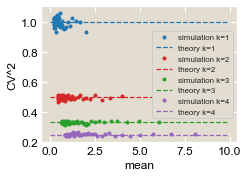

In [8]:
#Setting up our feature space
beta_min = 0.5 #Minimum transition rate
beta_max = 5 #Maximum transition rate
beta_step = 0.1 #Resolution in transition rates
beta_range = np.arange(beta_min,beta_max,beta_step)
n = np.array([2,3,4,5]) #Number of states

means = np.zeros((len(n),len(beta_range)))
CV2s = np.zeros((len(n),len(beta_range)))

#Simulate results
for i in range(len(n)):
    for j in range(len(beta_range)):
        Q = MakeGammaDistMatrix(n[i], beta_range[j])
        t_on = CalculatetOn_GenericMarkovChainGillespie(Q,n[i],N_cells)
        means[i,j] = np.mean(t_on)
        CV2s[i,j] = np.var(t_on)/np.mean(t_on)**2

#Plot results
meanVals = np.arange(0,10,0.1)
CV2Pred = np.zeros((len(n),len(meanVals)))
colors = ['tab:blue','tab:red','tab:green','tab:purple']
for i in range(len(n)):
    CV2Pred[i,:] = (1/(n[i]-1)) * np.ones(len(meanVals))
ToyModelFeatureSpace = plt.figure()
#plt.title('Feature space for equal, irreversible reactions')

for i in range(len(n)):
    plt.plot(means[i,:],CV2s[i,:],'.',label='simulation k=' + str(n[i]-1),color=colors[i])
    plt.plot(meanVals,CV2Pred[i,:],'--',label='theory k=' + str(n[i]-1),color=colors[i])
    
plt.xlabel('mean')
plt.ylabel('CV^2')
plt.legend()
StandardFigure(plt.gca())
plt.show()

What happens if we now allow for backwards transitions as an extension to this ideal case? We'll retain the idea of equal forward transition rates $\beta$, but now allow for equal backwards transitions of magnitude $\beta f$ (except from the final absorbing state $k$). 

\begin{equation}
0 \underset{\beta f}{\overset{\beta}{\rightleftharpoons}} 1 \underset{\beta f}{\overset{\beta}{\rightleftharpoons}} ... \overset{\beta}{\rightarrow} k
\end{equation}

We will investigate what happens when we vary $f$. Let's see what happens for $k=3$ steps.

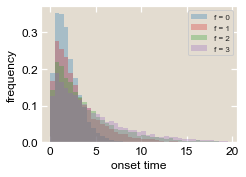

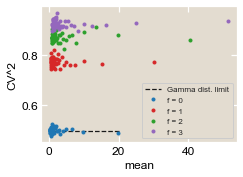

In [15]:
#Setting up parameters
n = 3
beta_min = 0.1
beta_max = 5.1
beta_step = 0.1
beta_range = np.arange(beta_min,beta_max,beta_step)
N_cells = 10000

#Backwards transitions
f = np.arange(0,4,1) #fractional magnitude of backwards transition relative to forwards
means = np.zeros((len(beta_range),len(f)))
CV2s = np.zeros((len(beta_range),len(f)))

for i in range(len(beta_range)):
    for j in range(len(f)):
        Q = MakeEqualBidirectionalMatrix(n,beta_range[i],f[j])
        t_on = CalculatetOn_GenericMarkovChainGillespie(Q,n,N_cells)
        means[i,j] = np.mean(t_on)
        CV2s[i,j] = np.var(t_on) / np.mean(t_on)**2
            
#Plot results
#Distribution for fixed beta and varying f
beta = 1
bins = np.arange(0,20,0.5)
t = np.arange(0,10,0.1)
colors = ['tab:blue','tab:red','tab:green','tab:purple']

BackwardsDist = plt.figure()

for i in range(len(f)):
    Q = MakeEqualBidirectionalMatrix(n,beta,f[i])
    t_on = CalculatetOn_GenericMarkovChainGillespie(Q,n,N_cells)
    plt.hist(t_on,bins=bins,density=True,alpha=0.3,label='f = ' + str(f[i]),
             linewidth=0,color=colors[i])

plt.xlabel('onset time')
plt.ylabel('frequency')
plt.legend()
StandardFigure(plt.gca())
plt.show()


BackwardsFeatureSpace = plt.figure()
#plt.title('Investigation of impact of backwards rates on feature space (k=2)')
plt.plot((n-1)/beta_range,(1/(n-1))*np.ones(beta_range.shape),'k--',label='Gamma dist. limit')

for i in range(len(f)):
    plt.plot(means[:,i],CV2s[:,i],'.',label='f = ' + str(f[i]),color=colors[i])
    
plt.xlabel('mean')
plt.ylabel('CV^2')
plt.legend()
StandardFigure(plt.gca())
plt.show()

We see that as the backwards transition rate increases, the overall noise increases! This makes intuitive sense, since with a backwards transition rate, the system is more likely to spend extra time hopping between states before reaching the final absorbing state, increasing the overall time to finish as well as the variability in finishing times.

Because actual irreversible reactions are effectively impossible to achieve in reality, the performance of the Gamma distribution model (i.e. equal, irreversible forward transitions) represents a bound to the noise performance of a real system. With this more realistic scenario of backwards transitions, the overall noise is higher.

# Transients help improve noise performance

In the steady-state regime, the only way to decrease the noise (i.e. squared CV) in onset times was to increase the number of steps. What about in the transient regime?

Here, we will investigate the changes to this parameter space by using a transient rate $\beta(t)$. This is of biological interest because many developmental processes occur out of steady state. For example, several models of chromatin accessibility hypothesize that the rate of chromatin state transitioning is coupled to the activity of pioneer factors like Zelda. During each rapid cell cycle division event in the early fly embryo, the nuclear membrane breaks down and reforms again, and transcription factors are expelled and re-introduced back into the nucleus. Thus, after each division event, there is a transient period during which the concentration of pioneer factors at a given gene locus is out of steady state.

For now, we will assume a reasonable form for the transition rate. Let's assume that forward transition rates are mediated by the concentration of a pioneer factor like Zelda, e.g. in some on-rate fashion. Considering $\beta$ to be a proxy for Zelda concentration, for example, we will write down this transient $\beta(t)$ as the result of a simple diffusive process with form

\begin{equation}
\beta(t) = \beta (1 - e^{-t / \tau} )
\end{equation}

Here, $\beta$ is the asymptotic, saturating value of $\beta(t)$, and $\tau$ is the time constant governing the time-varying nature of the transition rate. For a diffusive process, $\tau$ would be highly dependent on the diffusion constant, for example.

For comparison, the time plots of the constant and transient input are shown below, for $\tau = 3$ and $\beta = 1$.

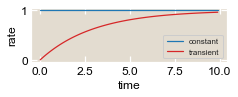

In [14]:
#Looking at steady-state vs input transient profiles
time = np.arange(0,10,0.1)
dt = 0.1
w_base = 1
w_const = w_base * np.ones(time.shape)
N_trans = 2
N_cells = 1000

#Now with transient exponential rate
tau = 3
w_trans = w_base * (1 - np.exp(-time / tau))

#Plot the inputs
TransientInputs = plt.figure()
#plt.title('Input transition rate profiles')
plt.plot(time,w_const,label='constant',color='tab:blue')
plt.plot(time,w_trans,label='transient',color='tab:red')
plt.xlabel('time')
plt.ylabel('rate')
plt.legend()
StandardFigure(plt.gca())
TransientInputs.set_figheight(1) #Make this figure short for formatting purposes
plt.show()

Because of the time-varying nature of $\beta(t)$, the resulting distribution $P_k(t)$ for the case of equal, irreversible forward transition rates no longer obeys a simple Gamma distribution, and an analytical solution is difficult (or even impossible). Nevertheless, we can easily simulate the distributions numerically, shown below.

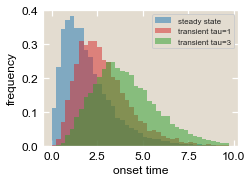

In [162]:
#Let's visualize the distribution of onset times for the case of equal, irreversible forward transition rates,
#comparing steady-state and transient input profiles, varying the "diffusion" constant tau

#Pick some parameters
beta = 1 #transition rate
n = 3 #Number of states
tau = np.array([1,3])

#Simulate the distributions
N_cells = 10000

#Steady state
Q_steady = MakeGammaDistMatrix(n, beta)
t_on_steady = CalculatetOn_GenericMarkovChainGillespie(Q_steady,n,N_cells)

#Transient
t_on_trans = np.zeros((len(tau),N_cells))

for i in range(len(tau)):
    Q = MakeGammaDistMatrix(n, beta) #Transition matrix
    t_on_trans[i,:] = CalculatetOn_GenericMarkovChainGillespieTime(Q,n,tau[i],N_cells)
    
#Plot results
bins = np.arange(0,10,0.25)
colors = ['tab:red','tab:green']
TransientDist = plt.figure()
#plt.title('Onset distributions for k=2 equal, irreversible transitions, steady-state vs. transient input')

plt.hist(t_on_steady,bins=bins,density=True,alpha=0.5,label='steady state',
         linewidth=0,color='tab:blue')
for i in range(len(tau)):
    plt.hist(t_on_trans[i,:],bins=bins,density=True,alpha=0.5,linewidth=0,
             label='transient tau=' + str(tau[i]),color=colors[i])

plt.xlabel('onset time')
plt.ylabel('frequency')
plt.legend()
StandardFigure(plt.gca())
plt.show()

We see that increasing the time constant $\tau$ results in a rightward shift of the onset time distribution, as expected since the time-varying transition rate profile will results in slower initial transition rates. What impact does this have on the noise? Below we show the feature space holding $k=2$ fixed while varying $\tau$, and then holding $\tau=3$ fixed and varying $k$.

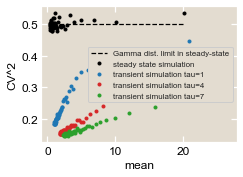

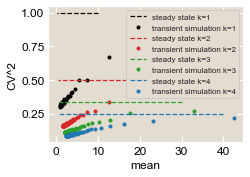

In [11]:
#Exploring the impact of transient inputs
#First, fix k and vary tau
n = 3 #number of states
beta_min = 0.1
beta_max = 5.1
beta_step = 0.1
beta_range = np.arange(beta_min,beta_max,beta_step)
tau = np.arange(1,10,3)

#Simulate the distributions
N_cells = 5000

#Steady state
means_steady = np.zeros(len(beta_range))
CV2s_steady = np.zeros(len(beta_range))
for i in range(len(beta_range)):
    Q = MakeGammaDistMatrix(n, beta_range[i])
    t_on = CalculatetOn_GenericMarkovChainGillespie(Q,n,N_cells)
    means_steady[i] = np.mean(t_on)
    CV2s_steady[i] = np.var(t_on) / np.mean(t_on)**2

#Transient
means_trans = np.zeros((len(tau),len(beta_range)))
CV2s_trans = np.zeros((len(tau),len(beta_range)))

for i in range(len(tau)):
    for j in range(len(beta_range)):
        Q = MakeGammaDistMatrix(n, beta_range[j]) #Transition matrix
        t_on = CalculatetOn_GenericMarkovChainGillespieTime(Q,n,tau[i],N_cells)
        means_trans[i,j] = np.mean(t_on)
        CV2s_trans[i,j] = np.var(t_on) / np.mean(t_on)**2
    
#Plot results
colors = ['tab:blue','tab:red','tab:green']
TransientFeatureSpaceFixedK = plt.figure()
#plt.title('Investigation of transient inputs on feature space (k=2, tau varying)')
plt.plot((n-1)/beta_range,(1/(n-1))*np.ones(beta_range.shape),
         'k--',label='Gamma dist. limit in steady-state',color='black')
plt.plot(means_steady,CV2s_steady,'k.',label='steady state simulation',color='black')
    
for i in range(len(tau)):
    plt.plot(means_trans[i,:],CV2s_trans[i,:],'.',
             label='transient simulation tau=' + str(tau[i]),color=colors[i])
    
plt.xlabel('mean')
plt.ylabel('CV^2')
plt.legend()
StandardFigure(plt.gca())
plt.show()

#Now fix tau and vary k
n =  np.array([2,3,4,5])
tau = 3

#Simulate the distributions
N_cells = 5000

#Transient
means_trans = np.zeros((len(n),len(beta_range)))
CV2s_trans = np.zeros((len(n),len(beta_range)))

for i in range(len(n)):
    for j in range(len(beta_range)):
        Q = MakeGammaDistMatrix(n[i], beta_range[j]) #Transition matrix
        t_on = CalculatetOn_GenericMarkovChainGillespieTime(Q,n[i],tau,N_cells)
        means_trans[i,j] = np.mean(t_on)
        CV2s_trans[i,j] = np.var(t_on) / np.mean(t_on)**2
    
#Plot results
colors = ['black','tab:red','tab:green','tab:blue']
TransientFeatureSpaceFixedTau = plt.figure()
#plt.title('Investigation of transient inputs on feature space (k varying, tau=3)')

for i in range(len(n)):
    plt.plot((n[i]-1)/beta_range,(1/(n[i]-1))*np.ones(beta_range.shape),'--',\
             color=colors[i],label='steady state k=' + str(n[i]-1))
    plt.plot(means_trans[i,:],CV2s_trans[i,:],'.',color=colors[i],\
             label='transient simulation k=' + str(n[i]-1))
    
plt.xlabel('mean')
plt.ylabel('CV^2')
plt.legend()
StandardFigure(plt.gca())
plt.show()

In each case, the transient input reduces noise! It seems like for increasing $\tau$, the performance improves. This makes intuitive sense because having a time-dependent input profile will make earlier transitions "weaker," so transitions that happen before the expected time are less likely, tightening the overall distribution of onset times. The relevant timescale is the dimensionless ratio $\frac{\beta}{\tau}$ - the faster the intrinsic transition rate $\beta$ is to the transient input timescale $\tau$, the larger the effects of the transient input. This manifests in the feature space for low values of the mean onset time, where the discrepancy between steady-state and transient is more apparent.

# Transient inputs can improve performance in non-ideal models
Earlier, we saw that in the steady-state case, the presence of finite backwards transition rates decreased the overall performance of the model in terms of noise. The greater the backwards transition rates, the worse the performance got. Here, we'll show that having transient inputs can counteract this performance loss.

As before, we'll assume a model with equal forward transition rates $\beta$ and equal backward transition rates $\beta f$. We'll compare the steady state case with the transient input case, parameterized with timescale $\tau$. Note that we'll only consider the forward transition rates to be transient, and assume the backward transition rates are still time-independent. Biologically, this would correspond to the forward transitions corresponding to on-rates of some pioneer factor like Zelda that is coupled to a time-dependent concentration profile, while backward transitions are time-independent off-rates.

Below, we explore the feature space in the steady-state vs. transient cases, with the steady-state ideal case of equal, irreversible transitions as a reference. We'll first consider the case fixing $k=2$ and $f=0.2$ and varying $\tau$.

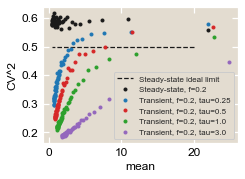

In [165]:
#Setting up parameters
n = 3
beta_min = 0.1
beta_max = 5.1
beta_step = 0.1
beta_range = np.arange(beta_min,beta_max,beta_step)
f = 0.2
tau = np.array([0.25,0.5,1,3])

#Simulate results
N_cells = 10000

#Steady state
means_steady = np.zeros(len(beta_range))
CV2s_steady = np.zeros(len(beta_range))

for i in range(len(beta_range)):
    Q = MakeEqualBidirectionalMatrix(n,beta_range[i],f)
    t_on = CalculatetOn_GenericMarkovChainGillespie(Q,n,N_cells)
    means_steady[i] = np.mean(t_on)
    CV2s_steady[i] = np.var(t_on) / np.mean(t_on)**2
    
#Transient
means_trans = np.zeros((len(beta_range),len(tau)))
CV2s_trans = np.zeros((len(beta_range),len(tau)))

for i in range(len(beta_range)):
    for j in range(len(tau)):
        Q = MakeEqualBidirectionalMatrix(n,beta_range[i],f)
        t_on =  CalculatetOn_GenericMarkovChainGillespieTime(Q,n,tau[j],N_cells)
        means_trans[i,j] = np.mean(t_on)
        CV2s_trans[i,j] = np.var(t_on) / np.mean(t_on)**2
            
#Plot results
colors = ['tab:blue','tab:red','tab:green','tab:purple']
TransientFeatureSpaceBackwards = plt.figure()
#plt.title('Impact of transient inputs on feature space with backward rates (k=2, f=' + str(f) + ')')
plt.plot((n-1)/beta_range,(1/(n-1))*np.ones(beta_range.shape),'k--',
         label='Steady-state ideal limit')
plt.plot(means_steady,CV2s_steady,'k.',label='Steady-state, f=' + str(f))

for i in range(len(tau)):
    plt.plot(means_trans[:,i],CV2s_trans[:,i],'.',
             label='Transient, f=' + str(f) + ', tau=' + str(tau[i]),color=colors[i])
    
plt.xlabel('mean')
plt.ylabel('CV^2')
plt.legend()
StandardFigure(plt.gca())
plt.show()

Interesting! As shown earlier, the steady-state case with a backwards transition rate is worse than the ideal limit with equal, irreversible forward rates. However, using a transient rate can counterbalance this and still achieve performance better than the ideal limit in the steady-state case.

This suggests that given a backwards transition rate that is some fraction $f$ in magnitude of the forwards transition rate, there exists some "diffusion" timescale $\tau$ of the input transition rate that can bring the squared CV back to the ideal steady-state limit with no backwards rates.

In [16]:
# Export figures

ToyModelDist.savefig('figures/ToyModelDist.pdf')
ToyModelFeatureSpace.savefig('figures/ToyModelFeatureSpace.pdf')
BackwardsDist.savefig('figures/BackwardsDist.pdf')
BackwardsFeatureSpace.savefig('figures/BackwardsFigureSpace.pdf')
TransientInputs.savefig('figures/TransientInputs.pdf')
TransientDist.savefig('figures/TransientDist.pdf')
TransientFeatureSpaceFixedK.savefig('figures/TransientFeatureSpaceFixedK.pdf')
TransientFeatureSpaceFixedTau.savefig('figures/TransientFeatureSpaceFixedTau.pdf')
TransientFeatureSpaceBackwards.savefig('figures/TransientFeatureSpaceBackwards.pdf')

NameError: name 'TransientInputs' is not defined